# A Deep Learning Approach to Real Estate

## Background
This notebook will take the classic Kaggle Real Estate problem and apply a deep learning approach using modern techniques including dropout, batch normalisation and mini-batch training.

## Shoutouts
Full credit for this technique goes to Andrew Beam and Max Berggren for their post that inspired this kernel (below). 
http://maxberggren.se/2017/06/18/deep-learning-vs-xgboost/ 

In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

seed = 123456
np.random.seed(seed)

In [203]:
target_variable = 'saleprice'
df = (
    pd.read_csv('input/train.csv') # change this to run on kaggle
    #pd.read_csv('../input/train.csv')

    # Rename columns to lowercase and underscores
    .pipe(lambda d: d.rename(columns={
        k: v for k, v in zip(
            d.columns,
            [c.lower().replace(' ', '_') for c in d.columns]
        )
    }))
    # Switch categorical classes to integers
    #.assign(**{target_variable: lambda r: r[target_variable].astype('category').cat.codes})
)
print('Done')

Done


In [22]:
df.head()


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


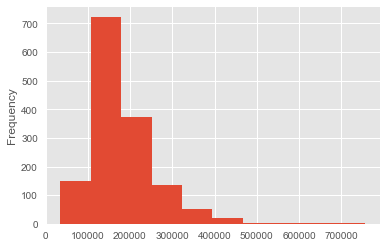

In [23]:
# Histagram of Sales Price
df['saleprice'].plot.hist()

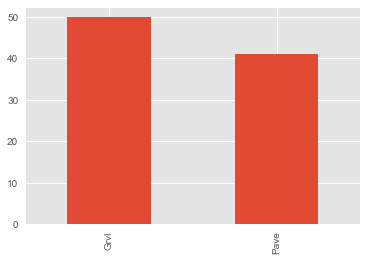

In [24]:
df['alley'].value_counts().sort_index().plot.bar()

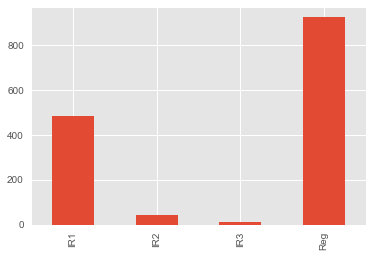

In [25]:
df['lotshape'].value_counts().sort_index().plot.bar()

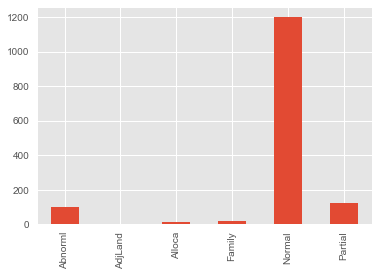

In [26]:
df['salecondition'].value_counts().sort_index().plot.bar()

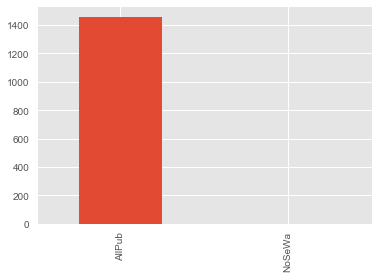

In [27]:
df['utilities'].value_counts().sort_index().plot.bar()

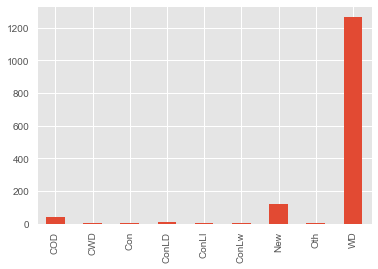

In [28]:
df['saletype'].value_counts().sort_index().plot.bar()

In [29]:
import sklearn.preprocessing as preprocessing
import seaborn as sns

In [204]:
# test label encoder
# it errored on 'Alley' Column
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(
    df['alley'].fillna(value='None')
)
le.classes_
le.transform(df['alley'].fillna(value='None')) 

array([1, 1, 1, ..., 1, 1, 1])

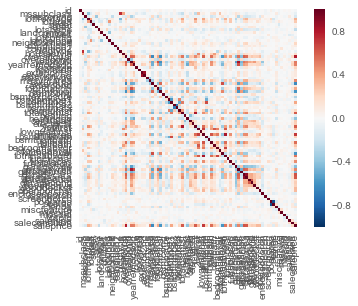

Done


In [205]:
# Encode the categorical features as numbers
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        #print(column)
        #print(result.dtypes[column])
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            # if there are NaN's in the categorical data fill it with 'None' which becomes another category
            result[column] = encoders[column].fit_transform(result[column].fillna(value='None'))
    return result, encoders

# Calculate the correlation and plot it
encoded_data, _ = number_encode_features(df)
sns.heatmap(encoded_data.corr(), square=True)
plt.show()

print('Done')

In [206]:
# Data is now in dataframe "encoded_data"

y = encoded_data[target_variable].values
X = (
    # Drop target variable
    encoded_data.drop(target_variable, axis=1)
    # Min-max-scaling (only needed for the DL model)
    .pipe(lambda d: (d-d.min())/d.max()).fillna(0)
    .as_matrix()
)
print('Done')

Done


In [207]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score

test_size = 0.0

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=seed
)
print('Done')

Done


In [34]:
# X and y shapes?
print(len(X_train))
print(len(y_train))

978
978


In [35]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Activation, Dropout
from keras import optimizers
print('Done')

Done


In [120]:
# Roll your own metric since
# Kaggle expects RMSE of the logs of predict and labels
import keras.backend as K

def log_rmse(y_true, y_pred):
    return K.mean(y_pred)
    #return K.sqrt( reduce_mean( K.pow( K.subtract(K.log(y_test_preds), K.log(y_test) ),2 ) ) ) 


In [208]:
dropout = 0.5
m = Sequential()
m.add(Dense(512, activation='relu', input_shape=(X.shape[1],)))
m.add(Dropout(dropout))
m.add(Dense(256, activation='relu'))
m.add(Dropout(dropout))
m.add(Dense(128, activation='relu'))
m.add(Dropout(dropout))
m.add(Dense(1, activation=None))  # linear activation for regression

m.compile(
    optimizer=optimizers.Adam(lr=0.002),
    loss='mean_squared_error',
    #metrics=[log_rmse]
)

print('Done')

Done


In [209]:
epochs = 200
batch_size= 256

print('Starting training....')

m.fit(
    # Feature matrix
    X_train,
    # Target class one-hot-encoded
    y_train,
    # Iterations to be run if not stopped by EarlyStopping
    epochs=epochs,
    callbacks=[
        # Stop iterations when validation loss has not improved
        EarlyStopping(monitor='val_loss', patience=25),
        # Nice for keeping the last model before overfitting occurs
        ModelCheckpoint(
            'best.model',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ],
    #verbose=2,
    validation_split=0.1,
    batch_size=batch_size
)
print('Done')



Starting training....
Train on 1314 samples, validate on 146 samples
Epoch 1/200
1314/1314 [==============================] - 1s - loss: 39545184150.0152 - val_loss: 34470031360.0000
Epoch 2/200
1314/1314 [==============================] - 0s - loss: 39530938520.7428 - val_loss: 34428915712.0000
Epoch 3/200
1314/1314 [==============================] - 0s - loss: 39455736612.2374 - val_loss: 34270799872.0000
Epoch 4/200
1314/1314 [==============================] - 0s - loss: 39206806501.5038 - val_loss: 33823549440.0000
Epoch 5/200
1314/1314 [==============================] - 0s - loss: 38564260765.8082 - val_loss: 32779096064.0000
Epoch 6/200
1314/1314 [==============================] - 0s - loss: 37122713852.4931 - val_loss: 30665676800.0000
Epoch 7/200
1314/1314 [==============================] - 0s - loss: 34361248239.6347 - val_loss: 26883061760.0000
Epoch 8/200
1314/1314 [==============================] - 0s - loss: 29711866540.2253 - val_loss: 20970940416.0000
Epoch 9/200
1314/13

In [179]:
# Load the best model
m.load_weights("best.model")

# Keep track of what class corresponds to what index
mapping = (
    pd.get_dummies(pd.DataFrame(y_train), columns=[0], prefix='', prefix_sep='')
    .columns.astype(int).values
)
#y_test_preds = [mapping[pred] for pred in m.predict(X_test).argmax(axis=1)]
y_test_preds = m.predict(X_test)
print('Done')

Done


In [180]:
# RMSLE
round(np.sqrt(sum(sum( ( np.log(y_test_preds) - np.log(y_test) )**2, 1)) / len(y_test)), 1 )

11.800000000000001

In [181]:
print( 'MSE: {0:.3f}'.format(np.sqrt(mean_squared_error(y_test, y_test_preds))) )

MSE: 41621.083


### Now for the Submission set

In [182]:
df = (
    pd.read_csv('input/test.csv') # change this to run on kaggle
    #pd.read_csv('../input/train.csv')

    # Rename columns to lowercase and underscores
    .pipe(lambda d: d.rename(columns={
        k: v for k, v in zip(
            d.columns,
            [c.lower().replace(' ', '_') for c in d.columns]
        )
    }))
    # Switch categorical classes to integers
    #.assign(**{target_variable: lambda r: r[target_variable].astype('category').cat.codes})
)
print('Done')

Done


In [163]:
# Check we have loaded the right dataset
# Make sure there is no SalePrice?
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [183]:
# make the dummy columns for categoricals
encoded_data, _ = number_encode_features(df)

X_sub = (# Min-max-scaling (only needed for the DL model)
    encoded_data.pipe(lambda d: (d-d.min())/d.max()).fillna(0)
    .as_matrix()
)
print('Done')

Done


In [189]:
# Run the model
y_sub_preds = m.predict(X_sub)

In [185]:
# Here are the predictions
y_sub_preds

array([[ 115464.921875],
       [ 166507.875   ],
       [ 196428.171875],
       ..., 
       [ 169374.140625],
       [ 108738.828125],
       [ 239954.625   ]], dtype=float32)

## Model Training for Kaggle

In [210]:
dropout = 0.5
m = Sequential()
m.add(Dense(1024, activation='relu', input_shape=(X.shape[1],)))
m.add(Dropout(dropout))
m.add(Dense(512, activation='relu'))
m.add(Dropout(dropout))
m.add(Dense(128, activation='relu'))
m.add(Dropout(dropout))
m.add(Dense(1, activation=None))  # linear activation for regression

m.compile(
    optimizer=optimizers.Adam(lr=0.002),
    loss='mean_squared_error',
    #metrics=[log_rmse]
)

print('Done')

epochs = 200
batch_size= 256

print('Starting training....')

m.fit(
    # Feature matrix
    X_train,
    # Target class one-hot-encoded
    y_train,
    # Iterations to be run if not stopped by EarlyStopping
    epochs=epochs,
    callbacks=[
        # Stop iterations when validation loss has not improved
        EarlyStopping(monitor='val_loss', patience=25),
        # Nice for keeping the last model before overfitting occurs
        ModelCheckpoint(
            'best.model',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ],
    #verbose=2,
    validation_split=0.1,
    batch_size=batch_size
)
print('Done')



Done
Starting training....
Train on 1314 samples, validate on 146 samples
Epoch 1/200
1314/1314 [==============================] - 1s - loss: 39542342654.4414 - val_loss: 34450432000.0000
Epoch 2/200
1314/1314 [==============================] - 0s - loss: 39473590605.5403 - val_loss: 34245902336.0000
Epoch 3/200
1314/1314 [==============================] - 0s - loss: 39102418672.8037 - val_loss: 33454888960.0000
Epoch 4/200
1314/1314 [==============================] - 0s - loss: 37865170410.9589 - val_loss: 31290042368.0000
Epoch 5/200
1314/1314 [==============================] - 0s - loss: 34799924509.2237 - val_loss: 26576480256.0000
Epoch 6/200
1314/1314 [==============================] - 0s - loss: 28634209521.5830 - val_loss: 18323922944.0000
Epoch 7/200
1314/1314 [==============================] - 0s - loss: 18889107591.5982 - val_loss: 8033488896.0000
Epoch 8/200
1314/1314 [==============================] - 0s - loss: 9102268668.4932 - val_loss: 4055387392.0000
Epoch 9/200
1314/

In [211]:
## Save to CSV with Image name and results
# Run the model
y_sub_preds = m.predict(X_sub)
pred = pd.DataFrame(data=y_sub_preds) 

print("Here is a sample...")

result = pd.concat([df['id'], pred], axis=1)
result.columns = ['Id','SalePrice'] 
print(result[0:10])

# Header: [image ALB BET DOL LAG NoF OTHER   SHARK   YFT]
result.to_csv('submission.csv', index = False)

print('Done')

Here is a sample...
   Id      SalePrice
0   1  107789.296875
1   2  153042.015625
2   3  169787.187500
3   4  186201.578125
4   5  168111.015625
5   6  168197.250000
6   7  163040.359375
7   8  163512.921875
8   9  181610.781250
9  10  114834.445312
Done
